# Preparation

In [ ]:
# Run this cell if you only opened this notebook in colab, and need to get all the sources
!git clone https://github.com/kokoslik/cartoonface-bot.git
import os
os.chdir('cartoonface-bot/src')

In [20]:
# Importing stuff that we need
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torch
from torch import nn
from data.dataset import SingleFolderDataset
from model.generator import Generator
from matplotlib import pyplot as plt

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Option 1: Horse2Zebra dataset

Run cells in this section to test on horse2zebra dataset

In [3]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

--2022-02-13 19:33:13--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111,45M  1,14MB/s    in 1m 51s  

2022-02-13 19:35:06 (1,00 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



In [6]:
!unzip -q horse2zebra.zip

In [23]:
pic_size=128
means = [0.5,0.5,0.5]
stds = [0.5,0.5,0.5]
transform = tt.Compose([tt.Resize(pic_size), tt.CenterCrop(pic_size), tt.ToTensor(), tt.Normalize(means, stds)])
datasets = {
    'testA':SingleFolderDataset('horse2zebra/testB', transform=transform,cache=True),
    'testB':SingleFolderDataset('horse2zebra/testA', transform=transform,cache=True)
}

# Option 2: Cartoon Faces dataset

Download the faces2k.zip from here:

and unzip it in the src directory

In [4]:
pic_size=128
means = [0.5,0.5,0.5]
stds = [0.5,0.5,0.5]
transformB = tt.Compose([tt.CenterCrop(320), tt.Resize(pic_size), tt.CenterCrop(pic_size), tt.ToTensor(), tt.Normalize(means, stds)])
transformA = tt.Compose([tt.Resize(pic_size), tt.CenterCrop(pic_size), tt.ToTensor(),tt.Normalize(means, stds)])
datasets = {
    'testA':SingleFolderDataset('faces2k/testB', transform=transformA, cache=True),
    'testB':SingleFolderDataset('faces2k/testA', transform=transformB, cache=True, ext='png')
}

# Dataloaders creation

In [24]:
batch_size = 16
dataloaders = {
    'testA': DataLoader(datasets['testA'], num_workers=2, shuffle=False, batch_size=batch_size),
    'testB': DataLoader(datasets['testB'], num_workers=2, shuffle=False, batch_size=batch_size)
}

# Models creation

In [25]:
# Choose a directory with dumps downloaded from links in the ReadMe, or
# generated by yourself with train notebook
dump_dir = 'dumps'
# Choose the epoch number (199 is last)
epoch_num = 199

# Models for faces dataset were trained without dropout
# If you choose to test these models, change dropout to False
model = {
    "genA": Generator(instance_norm=True, dropout=True).to(device),
    "genB": Generator(instance_norm=True, dropout=True).to(device)
}
for name, mod in model.items():
    mod.load_state_dict(torch.load(dump_dir+ '/' + name + f'_epoch{epoch_num}.pth', map_location=device))
with open(dump_dir + '/' + f'loss{epoch_num}.pkl', 'rb') as handle:
    losses = pickle.load(handle)

# Plot losses

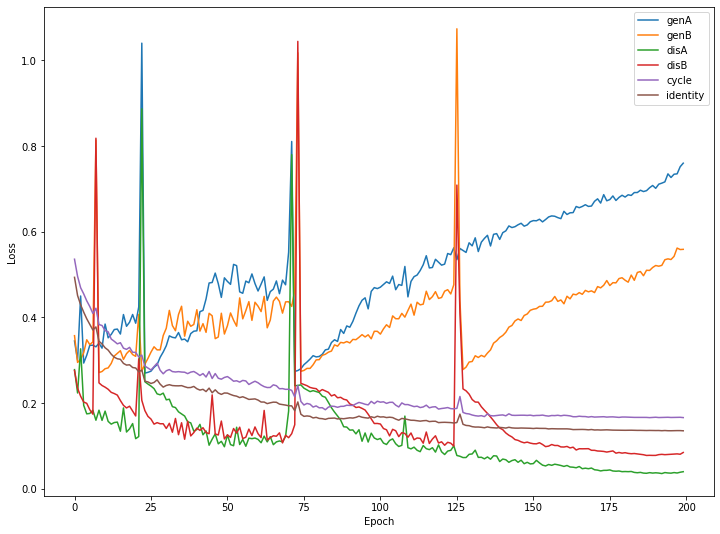

In [26]:
# Draw a plot of losses
plt.figure(figsize=(12,9))
for label, loss in losses.items():
    plt.plot(loss, label=label)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
None

# Plot some results

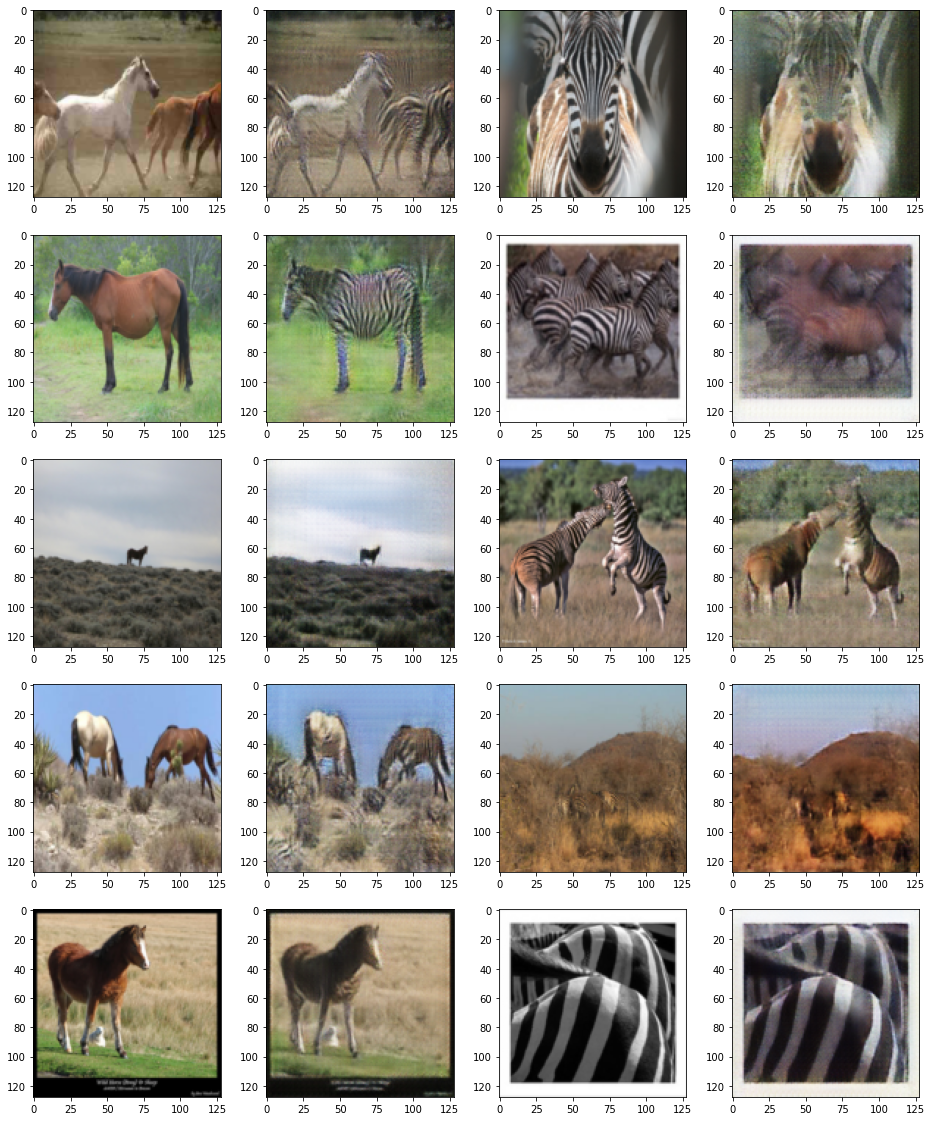

In [27]:
iterA = iter(dataloaders['testA'])
iterB = iter(dataloaders['testB'])
batchA = next(iterA).to(device)
batchB = next(iterB).to(device)
with torch.no_grad():
            model["genA"].eval()
            model["genB"].eval()
            fakeA_images = model["genA"](batchB)
            fakeB_images = model["genB"](batchA)
            
            plt.figure(figsize=(16,20))
            for i in range(5):
                plt.subplot(5,4,4*i+1)
                plt.imshow(np.moveaxis(batchB[i].cpu().detach().numpy(),0,-1)*0.5+0.5)
                plt.subplot(5,4,4*i+2)
                plt.imshow(np.moveaxis(fakeA_images[i].cpu().numpy(),0,-1)*0.5+0.5)
                plt.subplot(5,4,4*i+3)
                plt.imshow(np.moveaxis(batchA[i].cpu().detach().numpy(),0,-1)*0.5+0.5)
                plt.subplot(5,4,4*i+4)
                plt.imshow(np.moveaxis(fakeB_images[i].cpu().numpy(),0,-1)*0.5+0.5)
            plt.show()   

# Generate results for all test files

In [ ]:
os.mkdir('genAresults')
os.mkdir('genBresults')
for genKey, loaderKey in [('genA', 'testB'), ('genB', 'testA')]:
    for batchIdx, batch in enumerate(dataloaders[loaderKey]):
        batch = batch.to(device)
        with torch.no_grad():
            model[genKey].eval()
            fake_images = model[genKey](batch)

        fig = plt.figure(figsize=(20,10))
        for imIdx in range(batch.size(0)):
            plt.subplot(1,2,1)
            plt.imshow(np.moveaxis(batch[imIdx].cpu().numpy(),0,-1)*0.5+0.5)
            plt.subplot(1,2,2)
            plt.imshow(np.moveaxis(fake_images[imIdx].cpu().numpy(),0,-1)*0.5+0.5)
            plt.savefig(genKey+'results/'+f'Img{batchIdx}_{imIdx}.jpg')